In [1]:
!pip install -q pandas numpy matplotlib scikit-learn tqdm huggingface transformers torch


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import torch.nn.functional as F
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, matthews_corrcoef, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import random
import os
import string
import time
import re

In [3]:
SEED = 19
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    torch.cuda.manual_seed_all(SEED)
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

# Configuration
DATA_PATH_TRAIN = "/content/drive/MyDrive/emotion_dataset/train.txt"
DATA_PATH_TEST = "/content/drive/MyDrive/emotion_dataset/test.txt"
DATA_PATH_VAL = "/content/drive/MyDrive/emotion_dataset/val.txt"
MODEL_SAVE_PATH = "./best_emotion_classifier_model.pth"
CHECKPOINT_DIR = "./checkpoints"
BERT_MODEL_NAME = 'bert-base-uncased'
MAX_LEN = 256
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 2e-5
EPSILON = 1e-8
NUM_LABELS = 6
EARLY_STOPPING_PATIENCE = 3
RLROP_PATIENCE = 1
RLROP_FACTOR = 0.1

if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)


Using GPU: Tesla T4


# Data exploration

In [4]:
print("Loading datasets...")
df_train = pd.read_csv(DATA_PATH_TRAIN, delimiter=';', header=None, names=['sentence','label'])
df_test = pd.read_csv(DATA_PATH_TEST, delimiter=';', header=None, names=['sentence','label'])
df_val = pd.read_csv(DATA_PATH_VAL, delimiter=';', header=None, names=['sentence','label'])
print("Datasets loaded.")

# Show label distribution
print("\nTrain set label distribution:")
print(df_train['label'].value_counts(normalize=True)*100)
print("\nValidation set label distribution:")
print(df_val['label'].value_counts(normalize=True)*100)
print("\nTest set label distribution:")
print(df_test['label'].value_counts(normalize=True)*100)


Loading datasets...
Datasets loaded.

Train set label distribution:
label
joy         33.51250
sadness     29.16250
anger       13.49375
fear        12.10625
love         8.15000
surprise     3.57500
Name: proportion, dtype: float64

Validation set label distribution:
label
joy         35.20
sadness     27.50
anger       13.75
fear        10.60
love         8.90
surprise     4.05
Name: proportion, dtype: float64

Test set label distribution:
label
joy         34.75
sadness     29.05
anger       13.75
fear        11.20
love         7.95
surprise     3.30
Name: proportion, dtype: float64


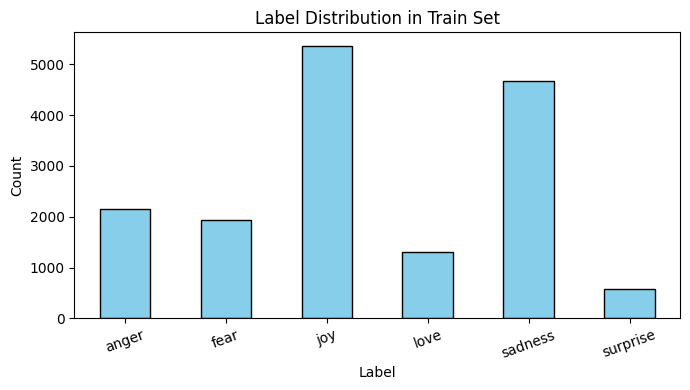

In [5]:
label_counts = df_train['label'].value_counts().sort_index()

plt.figure(figsize=(7, 4))
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in Train Set')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

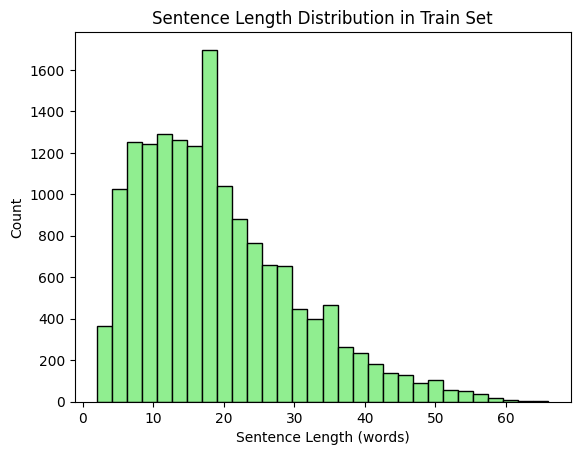

In [6]:
sentence_lengths = df_train['sentence'].apply(lambda x: len(x.split()))
plt.hist(sentence_lengths, bins=30, color='lightgreen', edgecolor='black')
plt.xlabel('Sentence Length (words)')
plt.ylabel('Count')
plt.title('Sentence Length Distribution in Train Set')
plt.show()

In [8]:
MAX_LEN = 128

In [8]:
df_train.describe()

,sentence,label
count,16000,16000
unique,15969,6
top,i feel on the verge of tears from weariness i ...,joy
freq,2,5362


In [9]:
df_test.describe()

,sentence,label
count,2000,2000
unique,2000,6
top,im feeling rather rotten so im not very ambiti...,joy
freq,1,695


In [10]:
df_val.describe()

,sentence,label
count,2000,2000
unique,1998,6
top,i feel so tortured by it,joy
freq,2,704


In [11]:
df_train.head()

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


# Preprocessing

In [12]:
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = remove_punctuation(text)
    return text

print("Applying text cleaning...")
df_train['sentence'] = df_train['sentence'].apply(clean_text)
df_val['sentence'] = df_val['sentence'].apply(clean_text)
df_test['sentence'] = df_test['sentence'].apply(clean_text)
print("Text cleaning complete.")

Applying text cleaning...
Text cleaning complete.


In [13]:
# Check for duplicates
datasets = {'train': df_train, 'validation': df_val, 'test': df_test}

for name, df in datasets.items():
    print(f"\n--- {name.upper()} SET ---")
    print("NaN counts per column:")
    print(df.isna().sum())
    print(f"Number of duplicate rows (all columns): {df.duplicated().sum()}")
    print(f"Number of duplicate sentences (ignore label): {df.duplicated(subset=['sentence']).sum()}")
    if df.duplicated(subset=['sentence']).sum() > 0:
        print("Duplicate sentences (showing first 5):")
        print(df[df.duplicated(subset=['sentence'])].head())


--- TRAIN SET ---
NaN counts per column:
sentence    0
label       0
dtype: int64
Number of duplicate rows (all columns): 1
Number of duplicate sentences (ignore label): 31
Duplicate sentences (showing first 5):
                                               sentence     label
5067  i feel on the verge of tears from weariness i ...       joy
6133              i still feel a craving for sweet food      love
6563  i tend to stop breathing when i m feeling stre...     anger
7623  i was intensely conscious of how much cash i h...   sadness
7685  im still not sure why reilly feels the need to...  surprise

--- VALIDATION SET ---
NaN counts per column:
sentence    0
label       0
dtype: int64
Number of duplicate rows (all columns): 0
Number of duplicate sentences (ignore label): 2
Duplicate sentences (showing first 5):
                                               sentence  label
603   i have had several new members tell me how com...    joy
1993                           i feel so torture

In [14]:
# Find all sentences that occur more than once, regardless of label
dup_sentences = df_train[df_train.duplicated(subset=['sentence'], keep=False)]

print(dup_sentences.sort_values('sentence'))

                                                sentence     label
8246   i am not amazing or great at photography but i...      love
3508   i am not amazing or great at photography but i...       joy
15705  i began to feel accepted by gaia on her own terms       joy
5277   i began to feel accepted by gaia on her own terms      love
8804   i bet taylor swift basks in the knowledge that...      fear
...                                                  ...       ...
11354  i write these words i feel sweet baby kicks fr...      love
7685   im still not sure why reilly feels the need to...  surprise
2908   im still not sure why reilly feels the need to...      fear
9596   ive also made it with both sugar measurements ...       joy
9069   ive also made it with both sugar measurements ...      love

[62 rows x 2 columns]


In [15]:
dup_sentences = df_train[df_train.duplicated(subset=['sentence'], keep=False)]
for sentence, group in dup_sentences.groupby('sentence'):
    labels = group['label'].unique()
    if len(labels) > 1:
        print(f"SENTENCE: {sentence}")
        print(f"  LABELS: {list(labels)}\n")


SENTENCE: i am not amazing or great at photography but i feel passionate about it
  LABELS: ['joy', 'love']

SENTENCE: i began to feel accepted by gaia on her own terms
  LABELS: ['love', 'joy']

SENTENCE: i bet taylor swift basks in the knowledge that the boys she writes songs about probably feel tortured
  LABELS: ['fear', 'anger']

SENTENCE: i cant escape the tears of sadness and just true grief i feel at the loss of my sweet friend and sister
  LABELS: ['love', 'joy']

SENTENCE: i could feel myself hit this strange foggy wall
  LABELS: ['fear', 'surprise']

SENTENCE: i feel a remembrance of the strange by justin aryiku falls into the latter category
  LABELS: ['surprise', 'fear']

SENTENCE: i feel im being generous with that statement
  LABELS: ['love', 'joy']

SENTENCE: i feel kind of strange
  LABELS: ['fear', 'surprise']

SENTENCE: i feel like a tortured artist when i talk to her
  LABELS: ['fear', 'anger']

SENTENCE: i feel like i am very passionate about youtube and so id quit

In [16]:
# Find all sentences that occur more than once, regardless of label in validation dataset
dup_sentences = df_val[df_val.duplicated(subset=['sentence'], keep=False)]

print(dup_sentences.sort_values('sentence'))

                                               sentence  label
774                            i feel so tortured by it   fear
1993                           i feel so tortured by it  anger
300   i have had several new members tell me how com...   love
603   i have had several new members tell me how com...    joy


In [17]:
# Dropping duplicates
train_label_counts = df_train['label'].value_counts()

# Identify sentences in train that appear with >1 label
dup_conflict = df_train.groupby('sentence')['label'].nunique()
conflict_sentences = dup_conflict[dup_conflict > 1].index

# For each conflicting sentence, drop the oversampled label
drop_indices = []
for s in conflict_sentences:
    group = df_train[df_train['sentence'] == s]
    # If more than 2 labels for this sentence, just keep the least common
    label_counts_in_group = group['label'].map(lambda lbl: train_label_counts[lbl])
    max_count = label_counts_in_group.max()
    oversampled_labels = group[label_counts_in_group == max_count]['label'].unique()
    to_drop = group[group['label'].isin(oversampled_labels)].index[0]
    drop_indices.append(to_drop)

df_train = df_train.drop(drop_indices).reset_index(drop=True)
print(f"Dropped {len(drop_indices)}")

Dropped 30


In [18]:
# Dropping duplicates in val dataset
val_label_counts = df_val['label'].value_counts()
dup_conflict_val = df_val.groupby('sentence')['label'].nunique()
conflict_sentences_val = dup_conflict_val[dup_conflict_val > 1].index

drop_indices_val = []
for s in conflict_sentences_val:
    group = df_val[df_val['sentence'] == s]
    label_counts_in_group = group['label'].map(lambda lbl: val_label_counts[lbl])
    max_count = label_counts_in_group.max()
    oversampled_labels = group[label_counts_in_group == max_count]['label'].unique()
    to_drop = group[group['label'].isin(oversampled_labels)].index[0]
    drop_indices_val.append(to_drop)

df_val = df_val.drop(drop_indices_val).reset_index(drop=True)
print(f"Dropped {len(drop_indices_val)} conflicting label duplicates from val set.")


Dropped 2 conflicting label duplicates from val set.


In [19]:
# Dropping duplicates in test dataset
test_label_counts = df_test['label'].value_counts()
dup_conflict_test = df_test.groupby('sentence')['label'].nunique()
conflict_sentences_test = dup_conflict_test[dup_conflict_test > 1].index

drop_indices_test = []
for s in conflict_sentences_test:
    group = df_test[df_test['sentence'] == s]
    label_counts_in_group = group['label'].map(lambda lbl: test_label_counts[lbl])
    max_count = label_counts_in_group.max()
    oversampled_labels = group[label_counts_in_group == max_count]['label'].unique()
    to_drop = group[group['label'].isin(oversampled_labels)].index[0]
    drop_indices_test.append(to_drop)

df_test = df_test.drop(drop_indices_test).reset_index(drop=True)
print(f"Dropped {len(drop_indices_test)} conflicting label duplicates from test set.")


Dropped 0 conflicting label duplicates from test set.


In [20]:
# Get unique sentences for each split
train_sentences = set(df_train['sentence'])
val_sentences = set(df_val['sentence'])
test_sentences = set(df_test['sentence'])

# Find overlap between test and train
test_in_train = test_sentences & train_sentences
print(f"Sentences in both test and train: {len(test_in_train)}")
if test_in_train:
    print("Example overlap with train:", list(test_in_train)[:5])

# Find overlap between test and validation
test_in_val = test_sentences & val_sentences
print(f"Sentences in both test and validation: {len(test_in_val)}")
if test_in_val:
    print("Example overlap with validation:", list(test_in_val)[:5])

# Find overlap with both train and validation
test_in_both = test_sentences & (train_sentences | val_sentences)
print(f"Sentences in test also in train or validation: {len(test_in_both)}")
if test_in_both:
    print("Example overlap:", list(test_in_both)[:5])


Sentences in both test and train: 11
Example overlap with train: ['i loved the feeling i got during an amazing slalom run whether it was in training or in a race', 'i found myself feeling inhibited and shushing her quite a lot', 'i feel cared for and accepted', 'i feel like some of you have pains and you cannot imagine becoming passionate about the group or the idea that is causing pain', 'i feel so weird and scattered with all wonders about a million different things']
Sentences in both test and validation: 3
Example overlap with validation: ['i feel like i am in paradise kissing those sweet lips make me feel like i dive into a magical world of love', 'i don t always feel like i have amazing style and most days i choose comfort over anything else but there is one thing that i feel makes all the difference in how i feel about myself and that is makeup', 'i feel not having a generous spirit or a forgiving nature closes me off from accepting gifts from the universe']
Sentences in test al

In [21]:
# Remove overlap: ensuring test sentences do NOT appear in train or val
train_sentences = set(df_train['sentence'])
val_sentences = set(df_val['sentence'])
test_sentences = set(df_test['sentence'])

# Remove from validation any sentence that is in train
val_overlap = val_sentences & train_sentences
df_val_cleaned = df_val[~df_val['sentence'].isin(train_sentences)].reset_index(drop=True)

# Remove from test any sentence that is in train or val
test_overlap = test_sentences & (train_sentences | val_sentences)
df_test_cleaned = df_test[~df_test['sentence'].isin(train_sentences | val_sentences)].reset_index(drop=True)

print(f"Original validation size: {len(df_val)}; Cleaned: {len(df_val_cleaned)}; Removed: {len(df_val) - len(df_val_cleaned)}")
print(f"Original test size: {len(df_test)}; Cleaned: {len(df_test_cleaned)}; Removed: {len(df_test) - len(df_test_cleaned)}")

df_val = df_val_cleaned
df_test = df_test_cleaned


Original validation size: 1998; Cleaned: 1993; Removed: 5
Original test size: 2000; Cleaned: 1986; Removed: 14


In [22]:
CLEAN_DIR = '/content/drive/MyDrive/emotion_dataset'

df_train.to_csv(f"{CLEAN_DIR}/train_cleaned.txt", sep=';', index=False, header=False)
df_val.to_csv(f"{CLEAN_DIR}/val_cleaned.txt", sep=';', index=False, header=False)
df_test.to_csv(f"{CLEAN_DIR}/test_cleaned.txt", sep=';', index=False, header=False)

In [4]:
# Loading cleaned dataset before training
df_train = pd.read_csv("/content/drive/MyDrive/emotion_dataset/train.txt", delimiter=';', header=None, names=['sentence','label'])
df_test = pd.read_csv("/content/drive/MyDrive/emotion_dataset/test_cleaned.txt", delimiter=';', header=None, names=['sentence','label'])
df_val = pd.read_csv("/content/drive/MyDrive/emotion_dataset/val_cleaned.txt", delimiter=';', header=None, names=['sentence','label'])
print("Datasets loaded.")

Datasets loaded.


In [7]:
labelencoder = LabelEncoder()
df_train['label_enc'] = labelencoder.fit_transform(df_train['label'])
df_test['label_enc'] = labelencoder.transform(df_test['label'])
df_val['label_enc'] = labelencoder.transform(df_val['label'])
actual_num_labels = len(labelencoder.classes_)
if actual_num_labels != NUM_LABELS:
    print(f"Warning: NUM_LABELS is set to {NUM_LABELS}, but found {actual_num_labels} unique labels.")
print(f"Labels encoded. Classes: {labelencoder.classes_}")


Labels encoded. Classes: ['anger' 'fear' 'joy' 'love' 'sadness' 'surprise']


In [9]:
def tokenize_sentences(sentences, tokenizer, max_len):
    if isinstance(sentences, pd.Series):
        sentences = sentences.tolist()
    encoding = tokenizer(
        sentences,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return encoding['input_ids'], encoding['attention_mask']

tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

train_inputs, train_masks = tokenize_sentences(df_train['sentence'], tokenizer, MAX_LEN)
val_inputs, val_masks = tokenize_sentences(df_val['sentence'], tokenizer, MAX_LEN)
test_inputs, test_masks = tokenize_sentences(df_test['sentence'], tokenizer, MAX_LEN)

train_labels = torch.tensor(df_train['label_enc'].values)
val_labels = torch.tensor(df_val['label_enc'].values)
test_labels = torch.tensor(df_test['label_enc'].values)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_loader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=BATCH_SIZE)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_loader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=BATCH_SIZE)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_loader = DataLoader(test_data, sampler=SequentialSampler(test_data), batch_size=BATCH_SIZE)

In [12]:
print(f"{BERT_MODEL_NAME}")
model = BertForSequenceClassification.from_pretrained(
    BERT_MODEL_NAME,
    num_labels=NUM_LABELS
)
model.to(device)
print("Model initialized.")

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=EPSILON)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=RLROP_FACTOR, patience=RLROP_PATIENCE, verbose=True)

best_val_accuracy = 0.0
best_val_loss_for_early_stop = np.inf
epochs_no_improve = 0


bert-base-uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model initialized.


In [13]:
def evaluate(eval_model, loader, device_to_use):
    eval_model.eval()
    all_losses = []
    all_true_labels = []
    all_preds = []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating", leave=False):
            batch = tuple(t.to(device_to_use) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            outputs = eval_model(b_input_ids, attention_mask=b_input_mask)
            loss = F.cross_entropy(outputs.logits, b_labels)
            all_losses.append(loss.item())
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_true_labels.extend(b_labels.cpu().numpy())
    avg_loss = np.mean(all_losses)
    accuracy = accuracy_score(all_true_labels, all_preds)
    mcc = matthews_corrcoef(all_true_labels, all_preds)
    return avg_loss, accuracy, mcc

In [14]:
total_training_start_time = time.time()

for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    print(f"\n======== Epoch {epoch + 1} / {EPOCHS} ========")
    print("Training...")
    model.train()
    total_train_loss = 0

    for step, batch in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    epoch_end_time = time.time()
    print(f"  Average training loss: {avg_train_loss:.4f}")
    print(f"  Epoch {epoch + 1} training time: {epoch_end_time - epoch_start_time:.2f} seconds")

    print("Running Validation...")
    val_loss, val_acc, val_mcc = evaluate(model, val_loader, device)
    print(f"  Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, MCC: {val_mcc:.4f}")

    scheduler.step(val_loss)

    checkpoint_path = os.path.join(CHECKPOINT_DIR, f"checkpoint_epoch_{epoch+1}.pth")
    torch.save(model.state_dict(), checkpoint_path)
    print(f"  Checkpoint saved to {checkpoint_path}")

    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"  New best model saved to {MODEL_SAVE_PATH} (Validation Accuracy: {best_val_accuracy:.4f})")

    if val_loss < best_val_loss_for_early_stop:
        best_val_loss_for_early_stop = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"  EarlyStopping: Validation loss did not improve for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
        print(f"  EarlyStopping: Stopping training as validation loss did not improve for {EARLY_STOPPING_PATIENCE} epochs.")
        break

total_training_end_time = time.time()
print("\nTraining complete.")
print(f"Total training time: {total_training_end_time - total_training_start_time:.2f} seconds")
print(f"Best validation accuracy: {best_val_accuracy:.4f}")



======== Epoch 1 / 10 ========
Training...


  Average training loss: 0.6368
  Epoch 1 training time: 297.79 seconds
Running Validation...


  Validation Loss: 0.1872, Accuracy: 0.9313, MCC: 0.9100
  Checkpoint saved to ./checkpoints/checkpoint_epoch_1.pth
  New best model saved to ./best_emotion_classifier_model.pth (Validation Accuracy: 0.9313)

======== Epoch 2 / 10 ========
Training...


  Average training loss: 0.1665
  Epoch 2 training time: 301.41 seconds
Running Validation...


  Validation Loss: 0.1703, Accuracy: 0.9338, MCC: 0.9134
  Checkpoint saved to ./checkpoints/checkpoint_epoch_2.pth
  New best model saved to ./best_emotion_classifier_model.pth (Validation Accuracy: 0.9338)

======== Epoch 3 / 10 ========
Training...


  Average training loss: 0.1152
  Epoch 3 training time: 301.87 seconds
Running Validation...


  Validation Loss: 0.1639, Accuracy: 0.9373, MCC: 0.9175
  Checkpoint saved to ./checkpoints/checkpoint_epoch_3.pth
  New best model saved to ./best_emotion_classifier_model.pth (Validation Accuracy: 0.9373)

======== Epoch 4 / 10 ========
Training...


  Average training loss: 0.0916
  Epoch 4 training time: 301.71 seconds
Running Validation...


  Validation Loss: 0.1678, Accuracy: 0.9353, MCC: 0.9161
  Checkpoint saved to ./checkpoints/checkpoint_epoch_4.pth
  EarlyStopping: Validation loss did not improve for 1 epoch(s).

======== Epoch 5 / 10 ========
Training...


  Average training loss: 0.0776
  Epoch 5 training time: 301.91 seconds
Running Validation...


  Validation Loss: 0.2102, Accuracy: 0.9348, MCC: 0.9144
  Checkpoint saved to ./checkpoints/checkpoint_epoch_5.pth
  EarlyStopping: Validation loss did not improve for 2 epoch(s).

======== Epoch 6 / 10 ========
Training...


  Average training loss: 0.0396
  Epoch 6 training time: 301.59 seconds
Running Validation...


  Validation Loss: 0.2194, Accuracy: 0.9368, MCC: 0.9171
  Checkpoint saved to ./checkpoints/checkpoint_epoch_6.pth
  EarlyStopping: Validation loss did not improve for 3 epoch(s).
  EarlyStopping: Stopping training as validation loss did not improve for 3 epochs.

Training complete.
Total training time: 1888.70 seconds
Best validation accuracy: 0.9373


In [16]:
os.makedirs('/content/drive/MyDrive/emotion_dataset/emotion_checkpoints', exist_ok=True)

# Move all checkpoint files
!mv /content/checkpoints/*.pth /content/drive/MyDrive/emotion_dataset/emotion_checkpoints/

# Move the best model file
!mv /content/best_emotion_classifier_model.pth /content/drive/MyDrive/emotion_dataset/emotion_checkpoints/


In [18]:
MODEL_SAVE_PATH = '/content/drive/MyDrive/emotion_dataset/emotion_checkpoints/best_emotion_classifier_model.pth'

if os.path.exists(MODEL_SAVE_PATH):
    model_size_bytes = os.path.getsize(MODEL_SAVE_PATH)
    model_size_mb = model_size_bytes / (1024 * 1024)
    print(f"Size of saved model: {model_size_mb:.2f} MB")
else:
    print(f"Model file not found at {MODEL_SAVE_PATH}, cannot determine size.")

print(f"\nLoading best model for test evaluation from {MODEL_SAVE_PATH}...")

if not os.path.exists(MODEL_SAVE_PATH) and epoch >= 0:
    print(f"Best model not found at {MODEL_SAVE_PATH}. Loading last checkpoint: {checkpoint_path}")
    final_model_path = checkpoint_path
elif not os.path.exists(MODEL_SAVE_PATH):
    print(f"Error: No model found at {MODEL_SAVE_PATH} and no checkpoints available. Exiting evaluation.")
    exit()
else:
    final_model_path = MODEL_SAVE_PATH

model_for_test = BertForSequenceClassification.from_pretrained(BERT_MODEL_NAME, num_labels=NUM_LABELS)
model_for_test.load_state_dict(torch.load(final_model_path, map_location=device))
model_for_test.to(device)
model_for_test.eval()


Size of saved model: 417.74 MB

Loading best model for test evaluation from /content/drive/MyDrive/emotion_dataset/emotion_checkpoints/best_emotion_classifier_model.pth...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [20]:
# Evaluation on test set
all_preds, all_labels = [], []
inference_start_time = time.time()

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing", leave=False):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        outputs = model_for_test(b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(b_labels.cpu().numpy())

inference_end_time = time.time()
inference_time = inference_end_time - inference_start_time
print(f"Test evaluation completed in {inference_time:.2f} seconds")

test_acc = accuracy_score(all_labels, all_preds)
test_mcc = matthews_corrcoef(all_labels, all_preds)

print("\n Test set evaluation")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Matthews Corrcoef: {test_mcc:.4f}")

test_precision_macro = precision_score(all_labels, all_preds, average='macro', zero_division=0)
test_recall_macro = recall_score(all_labels, all_preds, average='macro', zero_division=0)
test_f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
test_f1_weighted = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
test_conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Precision (macro): {test_precision_macro:.4f}")
print(f"Recall (macro): {test_recall_macro:.4f}")
print(f"F1 Score (macro): {test_f1_macro:.4f}")
print(f"F1 Score (weighted): {test_f1_weighted:.4f}")
print(f"Inference Time: {inference_time:.2f} seconds")

print("\nConfusion Matrix:")
print(test_conf_matrix)

print("\nClassification Report:")
target_names = labelencoder.classes_
try:
    print(classification_report(all_labels, all_preds, target_names=target_names, zero_division=0))
except ValueError as e:
    print(f"Could not generate classification report with target names. Error: {e}")
    print(classification_report(all_labels, all_preds, zero_division=0))

Test evaluation completed in 12.52 seconds

 Test set evaluation
Test Accuracy: 0.9320
Test Matthews Corrcoef: 0.9100
Precision (macro): 0.9112
Recall (macro): 0.8601
F1 Score (macro): 0.8812
F1 Score (weighted): 0.9301
Inference Time: 12.52 seconds

Confusion Matrix:
[[241  14   4   0  15   0]
 [  1 211   0   0   2  10]
 [  3   1 675   7   2   0]
 [  2   0  40 114   0   0]
 [  3   6   2   0 568   0]
 [  0  12   8   0   3  42]]

Classification Report:
              precision    recall  f1-score   support

       anger       0.96      0.88      0.92       274
        fear       0.86      0.94      0.90       224
         joy       0.93      0.98      0.95       688
        love       0.94      0.73      0.82       156
     sadness       0.96      0.98      0.97       579
    surprise       0.81      0.65      0.72        65

    accuracy                           0.93      1986
   macro avg       0.91      0.86      0.88      1986
weighted avg       0.93      0.93      0.93      1986



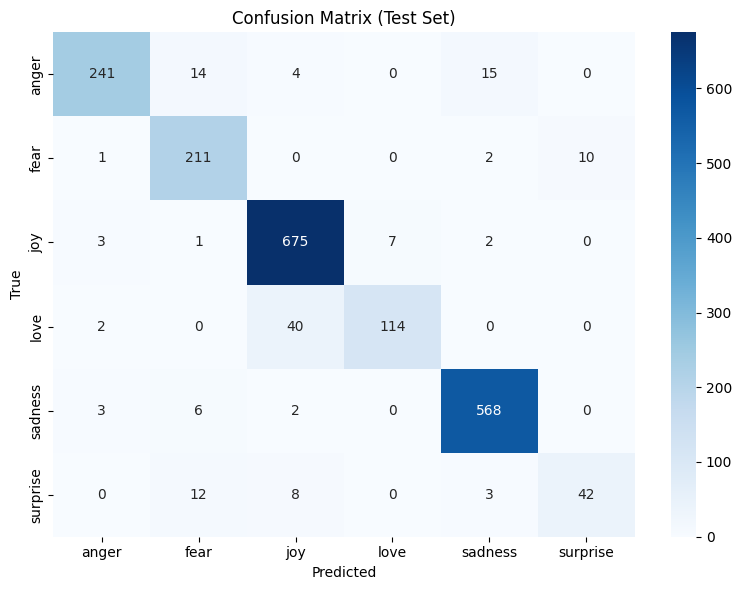

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)
labels = labelencoder.classes_

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()
